In [1]:
import numpy as np
import matplotlib.pyplot as plt
import contextlib as cl
import time

import readdy._internal as api
api.set_logging_level("debug")

sim = api.Simulation()
sim.set_kernel("CPU")

In [2]:
sim.periodic_boundary = [True, True, True]
sim.box_size = api.Vec(100., 25., 10.)

# register particle type
particle_radius = 1.0
diff = 0.05
sim.register_particle_type("B", diffusion_coefficient=0.4*diff, radius=particle_radius)
sim.register_particle_type("A", diffusion_coefficient=diff, radius=particle_radius)

# the potential that confines particles
origin = np.array([-46.,-10.,-0.001])
extent = np.array([92.,20.,0.002])
sim.register_potential_box("A", 200., api.Vec(*origin), api.Vec(*extent), False)
sim.register_potential_box("B", 200., api.Vec(*origin), api.Vec(*extent), False)

# reactions
sim.register_reaction_fission("birth", "A", "A", "A", rate=3.8e-1, product_distance=2.*particle_radius)
sim.register_reaction_enzymatic("eat", "B", "A", "B", rate=0.3e-1, educt_distance=2.*particle_radius)
sim.register_reaction_decay("decay", "B", rate=0.5e-1)

# add particles
rnd = np.random.uniform
origin_a = np.array([-42.,-10.,-0.001])
origin_b = np.array([-46.,-10.,-0.001])
small_extent = np.array([2.,20.,0.002])
for i in range(100):
    pos = origin_a + rnd(size=3) * small_extent * np.array([2., 1., 1.])
    sim.add_particle("A", api.Vec(*pos))
    pos = origin_b + rnd(size=3) * small_extent
    sim.add_particle("B", api.Vec(*pos))

In [3]:
# define observables and run
traj_handle = sim.register_observable_flat_trajectory(stride=50)

numbers_data = []
def append_numbers(x):
    global numbers_data
    numbers_data.append(x)
    print("A", x[0], "B", x[1])

sim.register_observable_n_particles(stride=500, types=["A", "B"], callback=append_numbers)
    
with cl.closing(api.File("./obs-wave.h5", api.FileAction.CREATE, api.FileFlag.OVERWRITE)) as f:
    traj_handle.enable_write_to_file(file=f, data_set_name="traj", chunk_size=10000)
    t1 = time.perf_counter()
    sim.run_scheme_readdy(True) \
        .write_config_to_file(f) \
        .with_reaction_scheduler("UncontrolledApproximation") \
        .with_skin_size(3.) \
        .configure_and_run(20000, 0.02)
    t2 = time.perf_counter()
print("Simulated", t2 - t1, "seconds")

A 100 B 100
A 46 B 965
A 58 B 695
A 170 B 684
A 12 B 813
A 79 B 530
A 125 B 636
A 96 B 687
A 113 B 707
A 91 B 765
A 59 B 680
A 64 B 632
A 204 B 689
A 81 B 821
A 105 B 781
A 124 B 819
A 106 B 820
A 219 B 825
A 223 B 1025
A 284 B 1320
A 291 B 1627
A 281 B 1726
A 309 B 2127
A 285 B 2210
A 177 B 2126
A 153 B 1867
A 234 B 1680
A 246 B 1715
A 255 B 1703
A 182 B 1770
A 158 B 1784
A 132 B 1508
A 220 B 1354
A 214 B 1411
A 370 B 1666
A 334 B 2023
A 227 B 2195
A 403 B 2107
A 184 B 2227
A 63 B 1833
A 75 B 1292
Simulated 174.48428624600092 seconds


In [4]:
# convert trajectory
t1 = time.perf_counter()
api.convert_xyz("./obs-wave.h5", "traj", "./traj-wave.xyz", radii={"A": 0.5, "B": 0.5})
t2 = time.perf_counter()
print("Conversion took", t2 - t1, "seconds")

Conversion took 0.7836982489989168 seconds


In [5]:
numbers = np.array(numbers_data)

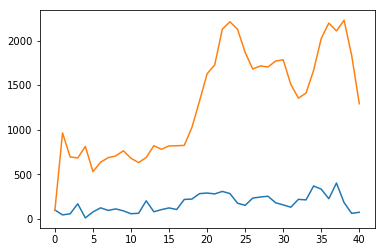

In [6]:
plt.plot(numbers[:,0])
plt.plot(numbers[:,1])
plt.show()

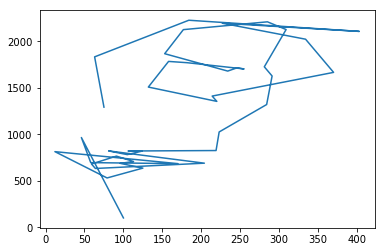

In [7]:
plt.plot(numbers[:,0], numbers[:,1])
plt.show()